# Bike Tripping

Now I need to handle the data transform for generating a list of bikes which started at each station and how many trips those bikes took, in total. That metadata (which I defered generating earlier until now) is necessary for the bike tripping component of the visualization.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import requests
import io
import zipfile
from tqdm import tqdm

In [2]:
stations = pd.read_csv("../data/final/june_22_station_metadata.csv", index_col=0)

In [3]:
june_22 = pd.read_csv("../data/final/all_june_22_citibike_trips.csv", index_col=0)

In [4]:
june_22.head(1)

,bikeid,birth year,end station id,end station latitude,end station longitude,end station name,gender,start station id,start station latitude,start station longitude,start station name,starttime,stoptime,tripduration,usertype
1004842,25585,1978.0,450,40.762272,-73.987882,W 49 St & 8 Ave,1,334,40.742388,-73.997262,W 20 St & 7 Ave,6/22/2016 00:00:11,6/22/2016 00:13:17,785,Subscriber


In [5]:
station_bikesets = {station_id: [] for station_id in stations.index}

for bike_id in tqdm(np.unique(june_22['bikeid'])):
    first_trip_station = june_22[june_22['bikeid'] == bike_id].sort_values(by='starttime').iloc[0]['start station id']
    station_bikesets[first_trip_station].append(bike_id)

100%|████████████████████████████████████| 6493/6493 [00:05<00:00, 1098.96it/s]


Some of these stations have a *lot* of outbounds, what's going on?

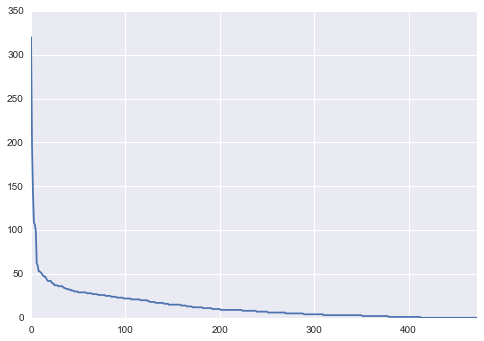

In [6]:
# Stations by number of bikes which started the day there.
pd.Series([len(station_bikesets[key]) for key in station_bikesets.keys()]).sort_values(ascending=False).reset_index(drop=True).plot()

In [7]:
pd.Series([len(station_bikesets[key]) for key in station_bikesets.keys()], index=station_bikesets.keys()).sort_values(ascending=False).head(5)

3230    320
3236    196
511     143
432     109
514     106
dtype: int64

In [8]:
stations.ix[[3230, 3236, 511, 432]]

,latitude,longitude,station name,incoming trips,outgoing trips,all trips,kind
station id,,,,,,,
3230,40.751284,-73.996924,Penn Station Valet,346,187,533,active
3236,40.758985,-73.993800,W 42 St & Dyer Ave,259,106,365,active
511,40.729387,-73.977724,E 14 St & Avenue B,224,199,423,active
432,40.726218,-73.983799,E 7 St & Avenue A,227,346,573,active


Ah. The top stations are all [Citi Bike valet service points](http://citibikeblog.tumblr.com/post/131225472957/citi-bike-valet-locations), which means that since they always have a full-time staffer on location they can overstock bikes like crazy. And indeed they do:

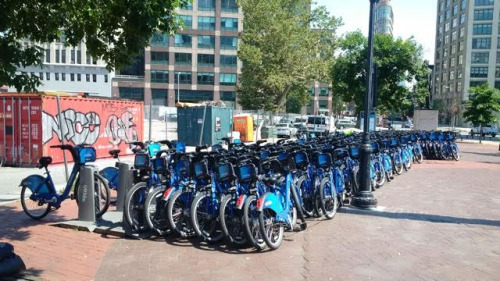

In [9]:
from IPython.display import Image
Image("../figures/West 42 and Dyker Valet Station Overstock.jpg")

I've a feeling this puts a decent dent in their transfer management problems, incidentally.

In [10]:
station_outbound_bike_count = dict()
station_outbound_trip_count = dict()

for station_id, bike_ids in tqdm(station_bikesets.items()):
    station_outbound_bike_count[station_id] = len(bike_ids)
    station_outbound_trip_count[station_id] = np.sum([len(june_22[june_22['bikeid'] == bike_id]) for bike_id in bike_ids])

100%|███████████████████████████████████████| 474/474 [00:02<00:00, 164.06it/s]


In [11]:
stations['bikes outbound'] = pd.Series(station_outbound_bike_count).astype(int)

In [12]:
stations['outbound trips'] = pd.Series(station_outbound_trip_count).astype(int)

In [13]:
stations.sort_values(by='bikes outbound', ascending=False)

,latitude,longitude,station name,incoming trips,outgoing trips,all trips,kind,bikes outbound,outbound trips
station id,,,,,,,,,
3230,40.751284,-73.996924,Penn Station Valet,346,187,533,active,320,3372
3236,40.758985,-73.993800,W 42 St & Dyer Ave,259,106,365,active,196,1930
511,40.729387,-73.977724,E 14 St & Avenue B,224,199,423,active,143,1391
432,40.726218,-73.983799,E 7 St & Avenue A,227,346,573,active,109,1041
514,40.760875,-74.002777,12 Ave & W 40 St,382,315,697,active,106,897
487,40.733143,-73.975739,E 20 St & FDR Drive,209,179,388,active,99,988
3177,40.786795,-73.977112,W 84 St & Broadway,162,162,324,active,62,622
3164,40.777057,-73.978985,Columbus Ave & W 72 St,188,140,328,active,60,609
3173,40.777507,-73.988886,Riverside Blvd & W 67 St,127,136,263,active,53,528


What's up with W 52 St?

In [14]:
w52outbounds = pd.concat([june_22[june_22['bikeid'] == bike_id] for bike_id in station_bikesets[520]])

In [15]:
w52outbounds['end station name'].value_counts()

Fulton St & Grand Ave      1
E 51 St & Lexington Ave    1
46 Ave & 5 St              1
Name: end station name, dtype: int64

Something...eh...whatever.

Wait a second, a lot of these zeroes make no sense.

In [16]:
pd.Series([len(station_bikesets[key]) for key in station_bikesets.keys()], index=station_bikesets.keys()).sort_values(ascending=False).tail(5)

386    0
137    0
153    0
375    0
337    0
dtype: int64

In [17]:
stations.ix[[498, 503, 3123, 517]]

,latitude,longitude,station name,incoming trips,outgoing trips,all trips,kind,bikes outbound,outbound trips
station id,,,,,,,,,
498,40.748549,-73.988084,Broadway & W 32 St,215,215,430,active,0,0
503,40.738274,-73.987520,E 20 St & Park Ave,0,0,0,inactive,0,0
3123,40.744697,-73.935404,31 St & Thomson Ave,5,8,13,active,0,0
517,40.751581,-73.977910,Pershing Square South,200,201,401,active,0,0


In [18]:
station_bikesets[498]

[]

In [19]:
stations.to_csv("../data/final/june_22_station_metadata.csv")